# 31. 고차 미분(이론편)

- 이전 단계에서는 현재의 DeZero 구현을 되돌아 봤습니다. 요점은 다음과 같습니다. 
    - 계산의 연결은 Function 클래스 \_\_call\_\_ 메서드에서 만들어집니다. 
    - 구체적인 순전파와 역전파 계산은 Function 클래스를 상속한 클래스의 forward 메서드와 backward 메서드로 처리합니다. 
- 여기서 주목할 점은 계산 그래프의 '연결'이 만들어 지는 시점입니다. 
    - 순전파를 계산할 때 만들어집니다. 
    - 역전파를 계산할 때는 만들어지지 않는데, 여기에 문제의 핵심이 있습니다. 

## 31.1 역전파 계산

- 순전파와 마찬가지로 역전파에도 구체적인 계산 로직이 있습니다. 
- 예를 들어 이전 단계에서 본 Sin 클래스의 backward 메서드 구현은 다음과 같습니다. 

In [ ]:
class Sin(Function):
    ...
    
    def backward(self, py):
        x = self.inputs[0].data
        gx = gy * np.cos(x) # (1)
        return gx           

- 위 (1)식과 같이 구체적인 계산이 이루어지지만, 현재의 DeZero는 이 계산과 관련된 아무런 계산 그래프도 만들지 않음
- 왜냐하면 이 계산에서는 ndarray 인스턴스가 사용되기 때문임
- 만약 역전파를 계산할 때도 '연결'이 만들어진다면 어떤 장점이 있을까요?
    - 바로 고차 미분을 자동으로 계산할 수 있게 됩니다!
- 아래 계산 그래프를 살펴 봅시다.   

![title](image/그림31-1.png)

- 위는 y = sin(x)의 계산 그래프입니다. 이 때 y.backward()를 호출하면 y의 x에 대한 미분이 구해집니다. 
- 아래 계산 그래프를 살펴봅시다. 

![title](image/그림31-2.png)

- 위는 'sin 함수의 미분'을 구하기 위한 계산 그래프입니다. 
- 이 계산 그래프는 sin 클래스의 역전파 코드 ```(gx = gy * np.cos(x))```를 계산 그래프로 나타낸 것입니다. 
- 만약 위 그림과 같은 계산 그래프가 있다면 ```gx.backward()```를 호출하여 gx의 x에 대한 미분을 계산할 수 있습니다. 
- 원래 gx는 y = sin(x)의 미분이기 때문에 ```gx.backward()```를 호출함으로써 x에 대한 미분이 한 번 더 이루어집니다. 
- 즉, 이것이 x의 2차 미분에 해당합니다. 
    - x를 시간으로 gx를 가속도로 바꿔서 생각해 보면, 위 그림은 '시간'을 입력하면 '속도'가 출력되는 계산그래프가 됨
    - 이 때 역전파를 하면 '속도'의 '시간'에 대한 미분(변화)가 구해지는데, 바로 '가속도'에 해당함
- 앞으로의 목표는 위 그림과 같은 '미분 계산'을 계산 그래프로 만드는 것입니다. 
- 여기서 '미분 계산'이라 함은, 다시 말해 역전파 때 수행되는 계산입니다. 
- 따라서 역전파 때 수행되는 계산에 대해서도 '연결'을 만들면 문제가 해결됩니다. 
- 이제 이 아이디어를 현실화 하는 방법을 생각해 보겠습니다. 

## 31.2 역전파로 계산 그래프 만들기

- DeZero는 순전파로 계산의 '연결'을 만듭니다. 
- 더 정확하게는 'Variable 인스턴스를 사용'하여 일반적인 계산(순전파)을 하는 시점에 '연결'이 만들어 집니다. 
- 이 말은 곧, 함수의 backward 메서드에서도 ndarray 인스턴스가 아닌 Variable 인스턴스를 사용하면 계산의 '연결'이 만들어진다는 뜻입니다. 
- 이를 위한 준비로 우선 미분값(기울기)을 Variable 인스턴스 형태로 유지해야 합니다. 
- 즉, Variable을 아래 그림처럼 변경합니다. 

![title](image/그림31-3.png)

- 위 그림에서 알 수 있듯이 지금까지 Variable 클래스의 grad는 ndarray 인스턴스를 참조했습니다. 
- 이를 Variable 인스턴스를 참조하도록 변경합니다. 
- 이렇게 변경하면 y = sin(x)를 아래와 같은 계산 그래프로 표현할 수 있습니다. 

![title](image/그림31-4.png)

- 위 그림은 Sin 클래스의 순전파와 역전파를 수행한 후의 계산 그래프입니다. 
- 중요한 점은 역전파 계산이 대한 계산 그래프도 만들어진다는 것입니다. 
- 미분값을 나타내는 gy가 Variable 인스턴스가 된 덕분에 gy를 사용한 계산에도 '연결'이 만들어지는 것입니다. 
    - y = sin(x) 계산에서 y.backward()를 수행하면 x와 같은 '말단 변수(사용자가 제공한 변수)'만 미분값을 유지합니다. 
    - y는 함수가 만들어내는 변수이므로 미분값을 유지하지 않기 때문입니다. 
    - 위 그림에서도 y.grad에서 gy로의 참조는 없습니다. 
- 위 그림에서는 Sin 클래스의 역전파 계산 내용을 생략했습니다. 
- Sin 클래스의 backward 메서드를 구현했을 때 그 미분을 계산하는 코드는 gx = gy * cos(x)였습니다. 
- 이 때의 변수가 모두 Variable 인스턴스로 바뀌었다고 생각해보죠.
- 그러면 위에서 생략된 역전파 계산은 실제로는 아래의 계산 그래프를 만듭니다. 

![title](image/그림31-5.png)

- 위 그림은 y.backward()를 호출함으로써 '새로' 만들어지는 계산 그래프입니다. 
- 즉, '역전파에 의해 새롭게 계산 그래프가 만들어졌다'는 뜻입니다. 
- 위와 같은 계산 그래프가 있다면 gx.backward()를 호출함으로써 y의 x에 대한 2차 미분이 이루어집니다. 
- 이상이 고차 미분을 계산하기 위한 전략입니다. 
- 다음 단계에서는 전략을 실제로 구현하겠습니다. 

# 32. 고차 미분(구현 편)

- 이번 단계에서는 고차 미분을 해낼 수 있도록 DeZero를 변경하겠습니다. 
- 이전 단계에서 이야기한 대로 역전파 시 수행되는 계산에 대해서도 계산 그래프를 만들면 됩니다. 
- 역전파 때도 Variable 인스턴스를 사용하면 해결된다는 것을 이전 단계에서 설명했으니, 이제 코드로 구현할 차례입니다. 
    - Variable 클래스를 core_simple.py에서 core.py으로 대체해서 새로 구현하겠습니다. 

## 32.1 새로운 DeZero로!

- 새로운 DeZero로 가는 가장 중요한 변화는 Variable 클래스의 인스턴스 변수인 grad 입니다. 
- 지금까지의 grad는 ndarry 인스턴스를 참조했습니다 
- 반면 새로운 DeZero에서는 다른 Variable 인스턴스를 참조하겠습니다. 
- 따라서 Variable 클래스의 아래 부분을 변경합니다. 

In [2]:
class Variable:
...

    def backward(self, retain_grad=False):
        if self.grad is None:
            # self.grad = np.ones_like(self.data)
            self.grad = Variable(np.ones_like(self.data))  # 이 부분 변경
        ...    

- 이와 같이 단 한줄만 바꾸면 됩니다. 
- 이 작은 변경 덕에 미분값을 자동으로 저장하는 코드에서 self.grad가 Variable 인스턴스를 담게 됩니다. 
- 이상으로 새로운 Variable 클래스를 완성했습니다. 

## 32.2 함수 클래스의 역전파

- 이제 DeZero의 구체적인 함수들의 backward 메서드를 수정하는 일이 남았습니다. (Function 클래스는 수정할 게 없습니다.)
- 지금까지는 core_simple.py 파일에서 다음 DeZero 함수 클래스를 구현했습니다. 
    - Add, Mul, Neg, Sub, Div, Pow
- 이번 단계에서는 이 클래스들의 backward 메서드를 수정한 다음 core.py로 옮기겠습니다. 
- 첫 번째인 Add 클래스는 수정할 게 아무것도 없습니다. Add 클래스의 구현은 아래와 같습니다. 

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy


![title](image/그림32-1a.png)

- Add 클래스의 역전파가 하는 일은 출력 쪽에서 전해지는 미분값을 입력 쪽으로 전달하는 게 다입니다. 
- 이처럼 역전파 때는 아무것도 계산하지 않기 때문에 수정할 거리도 없는 것입니다. (Sub 클래스도 마찬가지 입니다.)

![title](image/그림32-1b.png)

![title](image/그림32-1c.png)

- 위 그림과 같이 수정 전에는 Variable 인스턴스 안에 있는 데이터(ndarray 인스턴스)를 꺼내야 했습니다. 
- 한번 수정 후에는 Mul 클래스에서 Variable 인스턴스를 그대로 사용합니다. 
- 위 그림에서 주목할 점은 역전파를 계산하는 gy * x1 코드입니다. 
- 다시 말하지만 새로운 DeZero에서는 gy와 x1이 Variable 인스턴스입니다. 
- Variable 클래스의 $*$ 연산자는 이미 오버로드 되어 있으므로 gy * x1이 실행되는 뒤편에는 Mul 클래스의 순전파가 호출됩니다. 
- 그 때 Function.\_\_call\_\_()이 호출되고, 그 안에서 계산 그래프가 만들어집니다. 
    - 역전파 계산은 Variable 인스턴스에 대해 이루어집니다. 
    - 따라서 DeZero 함수에 Variable 인스턴스를 넣어 계산해야 합니다. 
- 나머지 Div, Pow 클래스의 backward 메서드는 아래를 참조하세요.     

![title](image/그림32-1d.png)

![title](image/그림32-1e.png)

## 32.3 역전파를 더 효율적으로 (모드 추가)

- 앞에서 역전파의 활성/비활성 모드를 도입했습니다. 
- 역전파가 필요 없는 경우에는 '역전파 비활성 모드'로 전환하여 역전파 처리(계산 그래프 생성과 입력 변수 유지 등)를 생략한 것입니다. 
- 이번 절에서는 역전파에서 수행하는 계산에도 같은 전략을 도입합니다. 
- 역전파를 처음 한 번 이후로 다시 할 일이 없다면 (역전파를 1회만 한다면) 역전파 계산도 '역전파 비활성 모드'로 실행하도록 하는 것입니다. 
- 이를 위해 Variable 클래스의 backward 메서드에 다음 코드를 추가합니다. 

In [16]:
def backward(self, retain_grad=False, create_graph=False): # create_graph를 추가하고 기본값 False, '역전파 비활성 모드'
    ...
    while funcs:
        f = funcs.pop()
        gys = [output().grad for output in f.outputs]  # output is weakref

        with using_config('enable_backprop', create_graph):  # 실제 역전파의 처리 수행
            gxs = f.backward(*gys)          # 메인 backward
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx    # 이 계산도 대상

                if x.creator is not None:
                    add_func(x.creator)

- 가령 Mul 클래스의 backward 메서드는 gy * x1 계산을 합니다. 
- 여기서 '$*$ 연산자'는 오버로드되어 있기 때문에 실제로는 Mul()(gy.x1) 코드가 호출되고,
- 이어서 부모 클래스인 Function의 ```__call__()```이 호출됩니다. 
- ```Function.__call__()```메서드에서 Config.enable_backprop이 참조되고, 역전파 활성/비활성 모드가 전환됩니다.
- 또한 ```create_graph = False```로 기본 설정한 이유는 실무에서 역전파가 단 1회만 수행되는 경우가 압도적으로 많기 때문입니다. 
- 만약 2차 이상의 미분이 필요하다면 ```create_graph = True```로 설정합니다. 
- 그러면 역전파를 계산할 때도 계산 그래프가 만들어지므로 역전파를 반복해서 할 수 있습니다. 

## 32.4 \_\_init\_\_.py 변경

- 이것으로 새로운 DeZero의 핵심은 완성되었습니다. 
- 지금까지 수정을 core.py에 넣고, 앞으로 simple_core.py 대신 core.py를 사용할 것이므로
- 초기화를 수행하는 \_\_init\_\_.py를 아래처럼 수정합니다. 

In [ ]:
# =============================================================================
# step23.py부터 step32.py까지는 simple_core를 이용해야 합니다.
is_simple_core = False  # True
# =============================================================================

if is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import Function
    from dezero.core_simple import using_config
    from dezero.core_simple import no_grad
    from dezero.core_simple import as_array
    from dezero.core_simple import as_variable
    from dezero.core_simple import setup_variable

else:
    from dezero.core import Variable
    from dezero.core import Parameter
    from dezero.core import Function
    from dezero.core import using_config
    from dezero.core import no_grad
    from dezero.core import test_mode
    from dezero.core import as_array
    from dezero.core import as_variable
    from dezero.core import setup_variable

- 이와 같이 ```is_simple_core = False```로 설정하여 주요 기능을 core.py에서 임포트하도록 바꿉니다. 
- 이것으로 고차 미분에 대응하는 core 파일을 임포트 할 수 있습니다. 
- 다음 단계에는 새로운 DeZero를 사용하여 고차 미분을 자동으로 계산해보겠습니다. 

# 33. 뉴턴 방법으로 푸는 최적화(자동 계산)

- 이번 단계에서는 새로운 DeZero를 사용하여 2차 미분도 자동으로 계산할 생각입니다. 
- 우선 간단한 수식의 2차 미분을 계산하고, 미분값이 제대로 구해졌음을 확인한 다음, 이어서 뉴턴 방법을 사용해 최적화하겠습니다. 

## 33.1 2차 미분 계산하기 

- $y = x^4 - 2x^2$ 이라는 수식의 2차 미분을 계산해봅시다. 
- DeZero를 사용하면 아래와 같이 구현할 수 있습니다. (사실 한 가지 문제가 있습니다.)

In [71]:
import numpy as np
# from dezero import Variable
from dezero.core import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)  # (1)
print(x.grad)

# 두 번째 역전파 진행
gx = x.grad   # (2)
gx.backward() # (3)
print(x.grad)

variable(24.0)
variable(68.0)


- 위 (1)의 ```y.backward(create_graph=True)```에 의해 첫번째 역전파가 진행됩니다. 이 때 인수 create_graph를 True로 지정하여 역전파 계산에 대해서도 계산 그래프를 만들게 했습니다. 
- 이제 역전파 계산 그래프에 다시 한 번 역전파할 차례입니다. 
- x의 2차 이분을 계산해야 하므로 먼저 (2)의 gx = x.grad 코드로 y의 x에 대한 미분값을 꺼냅니다. 
- 그리고 (3)에서는 방금 꺼낸 미분값인 gx에서 한번 더 역전파합니다. 
- 이렇게 하면 gx의 x에 대한 미분이 구해집니다. 
- 이 두 번째 미분이 바로 2차 미분에 해당합니다. 

- 코드를 실행하면 1차 미분이 24.0이고, 2차 미분이 68.0이 나옵니다. 
- 수식으로 확인하면 $y' = 4x^3 - 4x$이므로 x = 2 일 때의 1차 미분은 24입니다. 구현 결과와 일치합니다. 
- 그런데 2차 미분은 수식으로 $y'' = 12x^2 - 4$이므로 x = 2 일 때는 44입니다. 결과가 다릅니다!

- 앞의 코드가 내 놓은 68이라는 값은 1차 미분 결과(24)에 2차 미분 결과(44)가 '더해진' 값입니다. 
- 즉, Variable에 미분값이 남아 있는 상태에서 새로운 역전파를 수행했기 때문에 새로운 미분값이 '더해진' 것입니다. 

- 이 문제를 해결하려면 새로운 계산을 하기 전에 **Variable의 미분값을 '재설정'** 해야 합니다. 이를 반영하여 이전 문제를 다시 풀어봅시다.

- 복습! 
    - 역전파 시 ```x.backward(retain_grad = False)```처럼 retain_grad라는 인수가 False(기본값)이면 
    - 계산 과정에서 중간 변수의 미분값(기울기)은 자동으로 재설정됩니다. 
    - 따라서 말단 변수(사용자가 제공한 변수)만 미분값을 갖게 됩니다. 
    - 예컨데 x.backward()를 호출하면 x만 미분값을 유지합니다. 

In [72]:
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)  
print(x.grad)

# 두 번째 역전파 진행
gx = x.grad   
x.cleargrad()  # 미분값 재설정
gx.backward() 
print(x.grad)

variable(24.0)
variable(44.0)


- 보시다시피 gx.backward()를 부르기 전에 x.cleargrad()를 추가했습니다. 
- 이 한 줄이 x의 미분값을 재설정하여 역전파가 올바르게 이루어지게 합니다. 
- 실제로 앞이 코드를 실행하면 2차 미분의 결과는 44.0이 나오며, 수식으로 확인한 결과와 일치합니다. 

## 33.2 뉴턴 방법을 활용한 최적화

- 이제 뉴턴 방법을 활용해 최적화를 해볼 차례입니다. 우선 뉴턴 방법을 활용한 최적화의 수식을 다시 확인해 보죠.

![title](image/식33.1.png)

- 위 식과 같이 함수 f(x)의 1차 미분과 2차 미분을 사용하여 x를 갱신하고 있습니다. 
- 이 계산을 DeZero를 사용하여 자동으로 수행되도록 해봅시다. 

In [77]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
# from dezero import Variable
from dezero.core import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data


0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


- 이 코드는 29단계에서 구현한 코드에 기초하고 있습니다. 
- 지난 번에는 2차 미분을 '손으로' 계산해 하드코딩했지만, 이번에는 backward 메서드를 2번 실행하여 자동으로 계산하여 수정했습니다. 
- 위 코드의 x값의 갱신과정을 보면 불과 7회만에 최솟값 1에 도달했습니다. 
- 즉, 뉴턴 방법을 활용한 최적화를 자동으로 진행하게끔 한 구현이 올바르게 작동함을 알 수 있습니다!

# 34. sin 함수 고차 미분

- 지금까지 고차 미분에 대응하는 함수(Add, Mul, Neg, Sub, Div, Pow 클래스)를 구현하여 core.py에 추가해뒀습니다. 
- 이번 단계에서는 새로운 DeZero 함수 몇 개를 추가로 구현하겠습니다. 
- 앞으로 나오는 DeZero 함수는 functions.py에 추가하겠습니다. 
- 이 DeZero 함수들을 다른 파일에서 사용하려면 ```from dezero.functions import sin``` 형태로 임포트해야 합니다. 

## 34.1 sin 함수 구현

- 우선 고차 미분에 대응하는 새로운 Sin 클래스를 구현하겠습니다. y = sin(x)일 때 $dy/dx=cos(x)$ 입니다. 
- 따라서 Sin 클래스와 sin 함수는 다음처럼 구현할 수 있습니다. 

In [79]:
import numpy as np
from dezero.core import Function

class Sin(Function):
    def forward(self, x):
        y = xp.sin(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)   # (1)
        return gx


def sin(x):
    return Sin()(x)

- backward 메서드에 주목해보죠. bacward 메서드 안의 모든 변수가 Variable 인스턴스인 점이 중요합니다. (forward 메서드 안의 변수는 ndarry 인스턴스 입니다.)
- 따라서 (1)의 cos(x)는 DeZero의 cos 함수입니다. 
- 이는 Sin 클래스를 구현하려면 Cos 클래스와 cos 함수가 필요하다는 뜻입니다. 

- 또한 backward 메서드 구현 시 모든 계산은 반드시 DeZero 함수를 사용해야 합니다. 
- 만약 DeZero 함수가 없다면 새로 구현해야 합니다. 
- 앞의 gy * cos(x)에는 곱셈 연산자를 오버로드해 놓았기 때문에 DeZero의 mul 함수가 호출됩니다. 

## 34.2 cos 함수 구현

- 이어서 Cos 클래스와 cos 함수를 구현하겠습니다. 
- 수식으로는 y = cos(x) 일 때, $dy/dx=-sin(x)$ 입니다. 

In [80]:
class Cos(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x)
        y = xp.cos(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * -sin(x)
        return gx


def cos(x):
    return Cos()(x)

- 이번에도 backward 메서드에 주목해야 합니다. 
- backward에서의 구체적인 계산에서 sin 함수를 사용하고 있습니다. (앞에서 sin 함수를 구현했으므로 cos함수의 구현도 끝!)

## 34.3 sin 함수 고차 미분

- 다음 차례로 sin 함수의 고차 미분입니다. 
- 이번에는 2차 미분뿐 아니라 3차 미분, 4차 미분도 계산해 보겠습니다. 

In [82]:
import numpy as np
from dezero.core import Variable
import dezero.functions as F  # DeZero 함수를 F.sin(x), F.cos(x)처럼 간단하게 사용하기 위한 작업

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)  # n차 미분

variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


- for 문을 사용하여 역전파를 반복했습니다. 그에 따라 2차 미분, 3차 미분, .... 식으로 'n차 미분'이 구해집니다. 
- 이 for 문안에 코드는 지금까지와 다르지 않습니다. 
- 먼저 gx = x.grad에서 미분값을 꺼내 gx에서 역전파 하는 것입니다. 
- 그리고, 역전파를 하기 전에 ```x.cleargrad()```를 호출하여 미분밗을 재설정합니다. 
- 이 작업을 반복하여 n차 미분을 계산하고 있습니다. 

- 이어서 앞의 코드를 조금 확장하여 그래프를 그려보겠습니다. 코드는 다음과 같습니다!

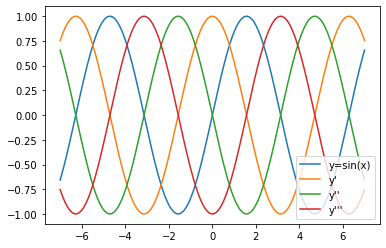

In [84]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
from dezero.core import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7, 200)) # (1)
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()


- 이전 코드와의 주요 차이는 (1) 부분으로 입력 변수를 ```x = Variable(np.linspace(-7, 7, 200))``` 형태로 설정했습니다. 
- -7부터 7까지 균일하게 200등분한 배열을 만들어 줍니다. 구체적으로는 $[-7., -6.92964823, -6.85929648, ..., 7.]$ 이라는 1차원 배열이 만들어 집니다. 
- 이렇게 만들어진 1차원 배열을 Variable로 감싸 x에 할당했습니다. 

- 입력 변수가 1차원 배열이 된 것을 제외하면 고차 미분을 계산하는 코드는 이전과 똑같습니다. 
- 그리고 지금까지 구현해온 DeZero 함수는 다차원 배열을 입력받으면 각 원소에 대해 독립적으로 계산합니다. 
- 따라서 한 번의 계산(순전파)으로 원소 200개의 계산이 모두 이루어집니다. 

- 넘파이 함수 대부분은 다차원 배열이 주어지면 원소별로 독립적으로 계산해줍니다. 그리고 DeZero 함수는 순전파 시 ndarray 인스턴스는 넘파이 함수를 사용하므로 DeZero 함수에 다차원 배열을 건네면 원소별 계산이 이루어집니다. 

![title](image/그림34-1.png)

- 코드를 실행하면 위 그림과 같이 y = sin(x)와 그 고차 미분 그래프를 얻을 수 있습니다. 
- 보시다시피 각각의 그래프는 파도 모양 위상이 '어긋난' 함수입니다. 
- 1차 미분, 2차 미분, 3차 미분, ... 식으로 차수가 증가함에 따라 $y = sin(x) → y = cos(x) → y = -sin(x) → y = -cos(x)$ 식으로 진행될 것입니다. 
- 이것으로 이번 단계를 마칩니다. 이번 단계에서는 DeZero에 sin 함수와 cos 함수를 새로 구현해 넣었습니다. 
- 다음 단계에서도 새로운 DeZero 함수를 추가할 것입니다. 

# 35. 고차 미분 계산 그래프

- 이전 단계에 이어 이번 단계에서도 DeZero 함수를 추가합니다. 
- 이번에 추가할 함수는 tanh입니다. tanh는 쌍곡탄젠트 혹은 하이퍼볼릭 탄젠트라고 읽습니다. 
- 수식은 아래와 같으며 모양은 아래 그림과 같습니다. 

![title](image/식35.1.png)

![title](image/그림35-1.png)

- 위와 같이 tanh 함수는 입력을 -1 ~ 1 사이의 값으로 변환됩니다. 
- 그럼 위 식의 미분인 $dy/dx$부터 구해봅시다. 

## 35.1 tanh 함수 미분

- tanh 함수의 미분은 다음의 미분 공식을 이용해 계산합니다. 

![title](image/식35.2.png)

- 위 식은 분수 함수의 미분 공식입니다. 여기에서는 f(x)의 x에 대한 미분을 $f'(x)$로 표기했습니다. 
- 이 때 자연로그의 밑(e)에 대해 $de^x/dx=e^x$이고 $de^{-x}/dx=e^{-x}$인 점을 이용하면 [식35.1] tanh 함수는 다음과 같이 미분할 수 있습니다. 

![title](image/식35.3.png)

- 위 식과 같이 tanh 함수의 미분은 '분수 함수의 미분'을 이용하여 간단한 식으로 변환할 수 있으며, 최종적으로는 $1-y^2$이라는 결과를 얻었습니다. 

## 35.2 tanh 함수 구현

- tanh 함수의 미분은 y = tanh(x)일 때 $dtanh(x)/dx=1 - y^2$입니다. 그래서 Tanh 클래스와 tanh 함수는 다음과 같이 구현할 수 있습니다. 

In [85]:
class Tanh(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x)
        y = xp.tanh(x)
        return y

    def backward(self, gy):
        y = self.outputs[0]()  # weakref
        gx = gy * (1 - y * y)  # gy * (1 - y **2)라고 작성해도 됩니다. 
        return gx
    
def tanh(x):
    return Tanh()(x)

- 순전파에서는 넘파이의 np.tanh 메서드를 이용합니다. 한편 역전파에서는 $gy * (1 - y * y)$ 형태로 구현합니다.
- 이상이 DeZero의 tanh 함수 구현입니다. 
- tanh 함수는 앞으로도 사용할 수 있도록 functions.py에 추가하겠습니다. 

## 35.3 고차 미분 계산 그래프 시각화

- DeZero의 tanh 함수를 구현했으니 이 함수를 사용하여 재미있는 실험을 하나 해보려 합니다. 
- 먼저 tanh 함수의 고차 미분을 계산하고, 그 계산 그래프를 시각화해보죠.
- 1차 미분, 2차 미분, 3차 미분, ... 식으로 진행하면서 어떤 계산 그래프가 만들어지는지 살펴보겠습니다. 
- 실험 코드는 다음과 같습니다. 

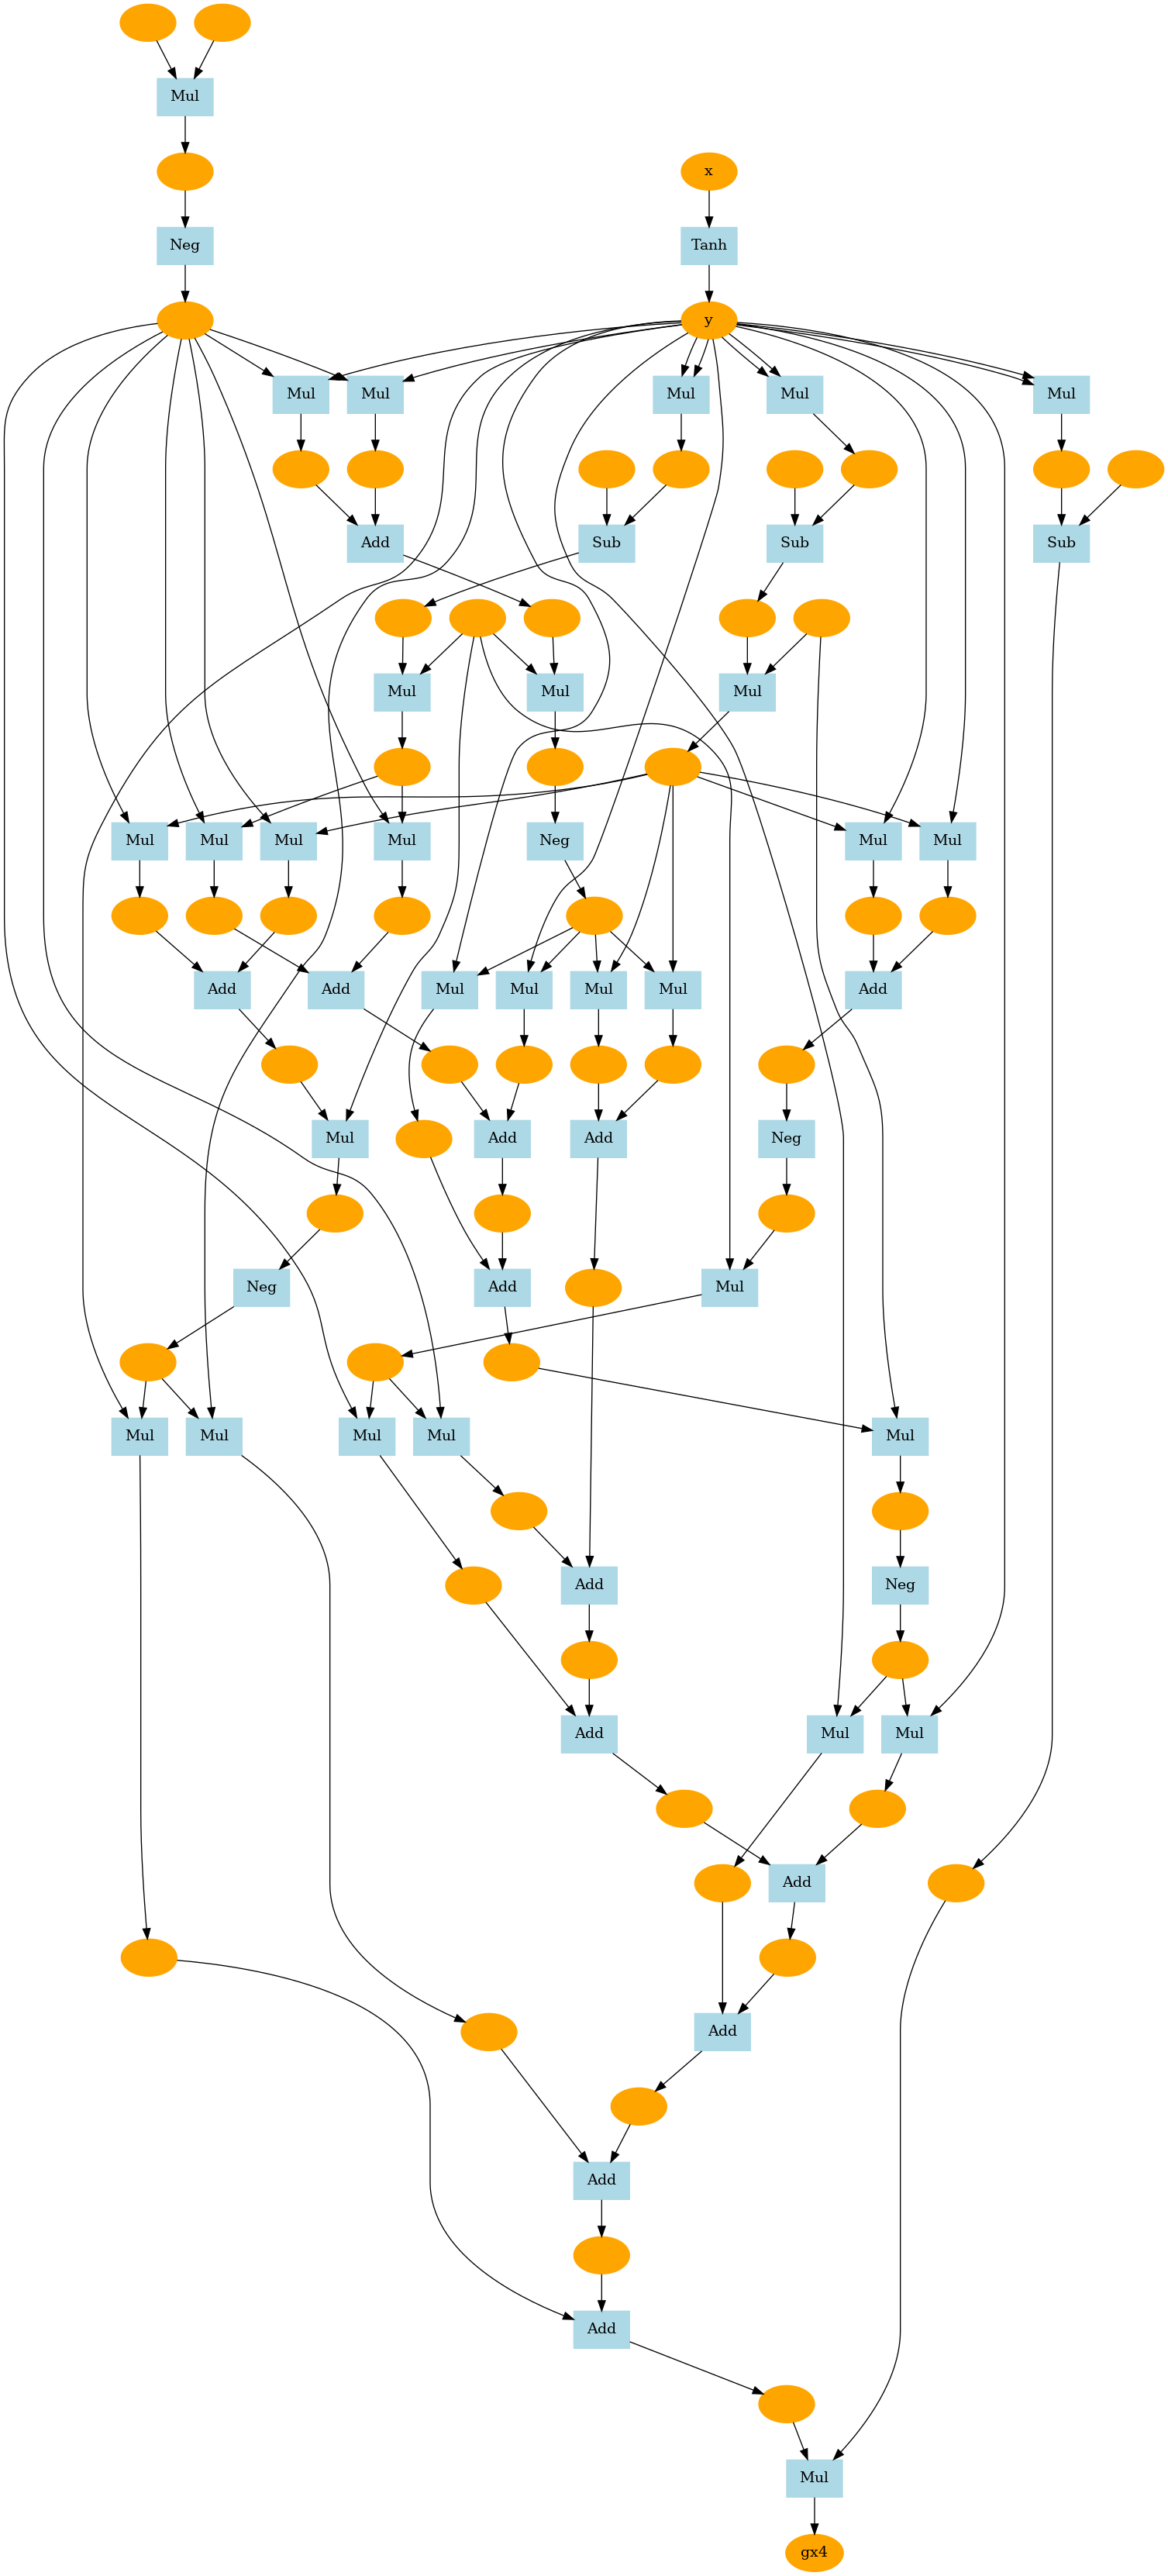

In [91]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero.core import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 3

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# 계산 그래프 그리기
gx = x.grad
gx.name = 'gx' + str(iters + 1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

- 지금까지 보아온 코드와 거의 같습니다. for 문에서 반복해서 역전파함으로써 고차 미분을 계산합니다. 
- 반복횟수는 iters 값으로 지정합니다. iters = 0 이면 1차 미분이, 1이면 2차 미분이 계산되는 식입니다. 
- 마지막으로 생성된 계산 그래프를 시각화 합니다. 

- 우선 iters = 0일 때의 계산 그래프를 보겠습니다. 결과는 아래와 같습니다. 

![title](image/그림35-2.png)

- 위 그림은 y = tanh(x)의 1차 미분을 계산하기 위한 계산 그래프입니다. 
- DeZero 함수 중 Tanh, Mul, Sub가 사용되고 있음을 알 수 있습니다. 
- 이어서 iters 값을 변경하여 2~5차 미분을 계산해보겠습니다. 어떤 그래프가 만들어질까요? 결과는 아래와 같습니다. 

![title](image/그림35-3.png)

- 위 그림에서 보듯 차수가 늘어날수록 계산 그래프도 복잡해집니다. 
- 역전파를 할 때마다 기존까지의 계산에 대한 새로운 계산 그래프가 만들어지므로 노드 수가 기하급수적으로 증가합니다. 
- 그림을 보니 마치 세포가 분열하는 듯 합니다. 
- 계속해서 아래 그림은 6차 미분과 7차 미분의 결과입니다. 

![title](image/그림35-4.png)

- 매우 복잡한 계산 그래프가 만들어졌습니다. 이 정도로 복잡한 계산 그래프를 손으로 그리는 것은 거의 불가능할 것 같습니다. 
- DeZero는 분명 우리 손으로 만들었지만, DeZero 활용해 '우리 이상의 무언가'를 만들어낸 순간입니다!
- 이런 점이 컴퓨터와 프로그래밍의 매력이 아닐까 싶습니다. 
- 이 계산 그래프들의 고해상도 버전을 

![title](image/그림35-5.png)

- 계산 그래프가 한층 더 복잡해졌습니다. 지면으로는 노드의 형태조차 확인할 수 없을 정도이지요.

# 36. 고차 미분 이외의 용도

- 지금까지 여러 단계를 거쳐 DeZero로 고차 미분을 계산해봤습니다. 
- 본질적으로는 한 가지 일을 한 셈인데, 바로 역전파 시 수행되는 계산에 대해서도 '연결'을 만들도록 했습니다. 
- 여기에서 중요한 점은 역전파의 계산 그래프를 만드는 기능 자체가 DeZero의 새로운 능력이라는 사실입니다. 
    - 새로운 DeZero에서는 역전파로 수행한 계산에 대해 또 다시 역전파할 수 있습니다. 
    - 이를 double backpropagation이라고 합니다. (이후 double backprop으로 줄여 표기)
    - double backprop은 현대적인 딥러닝 프레임워크 대부분이 지원합니다. 
- 고차 미분은 이 능력을 응용한 한 가지 예에 지나지 않습니다. 
- 그래서 이번 단계에서는 새로워진 DeZero를 고차 미분 외에 또 어떻게 활용할 수 있는지 살펴보겠습니다. 

## 36.1 double backprop의 용도

- 고차 미분 외에 double backprop을 또 어디에 활용할 수 있을까요? 우선 다음 문제를 생각해 봅시다. 

- [문제] 다음의 두 식이 주어졌을 때 x = 2.0에서 x에 대한 z의 미분 $dz/dx$를 구하라

![title](image/식36.1.png)

![title](image/식36.2.png)

- 지금까지와 같은 미분 계산 문제지만 위 식에 이미 미분이 포함되어 있는 점이 다릅니다. 
- 즉, 미분이 포함된 식에서 다시 한 번 미분해야 합니다. 
- 이 문제도 double backprop으로 계산할 수 있습니다. 
- 설명에 앞서 $dy/dx$를 손으로 계산해보겠습니다. 다음은 전개 과정입니다. 

- $dy/dx=2x$
- $z = (dy/dx)^3 + y=8x^3 + x^2$
- $dy/dx=24x^2 + 2x$

- 식을 이와 같이 전개한 후 $24x^2 + 2x$에 x = 2.0을 대입하면 100.0이라는 답을 얻을 수 있습니다. 
- 위 식에서 $dy/dx$는 값이 아니라 x의 식입니다. 만약 여기에서 x = 2.0일 때 $dy/dx$의 값을 찾고, 그 값을 $z = (dy/dx)^3 + y$에 대입하면 올바른 결과를 얻을 수 있습니다. 
- 이상의 내용을 바탕으로 같은 문제를 DeZero를 사용해 풀어봅시다. 코드는 다음과 같습니다. 

In [94]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero.core import Variable

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

variable(100.0)


- 이 코드에서 중요한 부분은 ```y.backward(create_graph = True)```입니다. 
- 미분을 하기 위해 역전파하는 코드죠. 
- 이 코드가 새로운 계산 그래프를 생성합니다. (지금의 경우 $2*x$라는 계산 그래프가 자동으로 생성됩니다.)
- 그리고 역전파가 만들어낸 계산 그래프를 사용하여 새로운 계산을 하고 다시 역전파합니다. 
- 이렇게 하면 미분이 올바르게 이루어집니다. 
- ```gx = x.grad```는 단순한 변수(값)이 아니라 계산 그래프(식)입니다. 
- 따라서 x.grad의 계산 그래프에 대해 추가로 역전파할 수 있습니다. 
- 이상과 같은 형태의 문제(미분의 식을 구하고, 그 식을 사용하여 계산한 다음, 또 다시 미분하는 문제)를 double backprop으로 해결할 수 있습니다. 
- 딥러닝 연구에서도 많이 볼 수 있는 유형의 문제로 다음 절에서는 딥러닝 연구에서 사용한 예를 몇 가지 소개하겠습니다. 

## 36.2 딥러닝 연구에서의 사용 예

- 딥러닝에서 double backprop을 사용하는 연구는 여러 가지입니다. 
- 예를 들어 WGAN-GP 논문에서는 아래 그림의 수식을 최적화 합니다. 

![title](image/그림36-1.png)

- 위 그림에서 주목할 점은 최적화하는 식의 기울기(텐서의 각 원소에 대한 미분 결과)가 들어있다는 것입니다. 
- 이 기울기는 첫 번째 역전파에서 구할 수 있습니다. 
- 그리고 이 기울기를 사용하여 함수 L을 계산하고 함수 L을 최적화하기 위해서 두 번째 역전파를 합니다. 

- 이와 같이 최신의 연구에서도 double backprop이 사용됩니다. 
- WGAN-GP 외에 MAML과 TRPO 등 유명한 double backprop 기능이 실제로 사용되고 있답니다. 
    - TRPO에서는 해세 행렬과 벡터의 곱을 구할 때 double backprop을 사용합니다. 
    - double backprop을 사용하면 계산 효율이 좋아지죠. 
    - 해세 행렬과 벡터의 곱에 관해서는 이어지는 '칼럼: 뉴턴 방법과 double backprop 보충학습'에서 설명합니다. 
    
- 이제 제 3고지도 정복했습니다. 
- 이번 고지에서는 DeZero의 역전파를 수정하여 double backprop이 가능하게 되었습니다. 
- 이를 통해 고차 미분에 필요한 뉴턴 방법을 구현할 수 있었습니다. 
- 다음 고지부터는 DeZero를 본격 신경망용으로 탈바꿈시킬 계획입니다. 

## 칼럼: 뉴턴 방법과 double backprop 보충학습

- 이번 칼럼은 제3고지의 내용을 보충합니다. 
- 먼저 입력이 벡터이 경우에 뉴턴 방법에 대해 설명하고, 이어서 뉴턴 방법을 대체할 수 있는 또 다른 방법을 소개합니다. 
- 마지막으로 double backprop의 실용적인 쓰임 예를 추가합니다. 

### 다변수 함수의 뉴턴 방법

- 제3고지에서 뉴턴 방법을 구현하면서 $y = x^4 - 2x^2$이라는 수식의 최솟값을 뉴턴 방법으로 구했습니다. 
- 보는 바와 같이 이 식에서 입력 변수는 x뿐입니다. 
- 따라서 우리가 한 일은 정확히 '입력 변수가 하나(스칼라)인 경우의 뉴턴 방법을 구현'한 것입니다. 
- 그렇다면 입력이 다차원 배열일 경우의 뉴턴 방법은 어떻게 다를까요?
- 여기서는 입력 변수를 벡터 **X**로 바꾸고 함수 $y=f(X)$에 대해 생각해봅시다. 
- 이 때 **x**는 벡터이며 $X=(x_1, x_2, ..., x_n)$ 형태로 n개의 원소를 갖습니다. 
    - 변수가 스칼라가 아닌 경우 **X**처럼 굵은 글씨로 표기하고, 스칼라이면 x처럼 보통 굵기로 표기합니다. 
- 그러면 y = f(x)에 대한 뉴턴 방법은 다음과 같아집니다.     
    
![title](image/식C.1.png)

- 우선 기호의 뜻부터 설명하겠습니다. $▽f(x)$는 기울기(gradient)를 나타냅니다. 
- 기울기는 X의 각 원소에 대한 미분으로, 원소까지 표기하면 다음과 같습니다. 

![title](image/식C.2.png)

- 그리고 $▽^2f(x)$는 헤세 행렬(Hessian matrix)입니다. 헤세 행렬의 식은 다음과 같습니다. 

![title](image/식C.3.png)

- 위 식과 같이 헤세 행렬은 X의 두 원소에 대한 미분입니다. 두 원소 조합이 이루어지기 때문에 행렬 형태로 정의됩니다. 
- 기울기 $▽f(x)$는 $df/dx$라고 표기할 수도 있고, 헤세 행렬 $▽^2f(x)$는 $d^2f/dx^T$라고 표기할 수도 있습니다. 
- [식 C.1]에서는 기울기와 헤세 행렬을 사용하여 x를 갱신했습니다. 
    - 이 때 X를 기울기 방향으로 갱신하고 그 진행 거리를 헤세 행렬의 역행렬을 사용하여 조정합니다. 
    - 헤세 행렬이라는 2차 미분 정보를 이용함으로써 더 공격적으로 진행할 수 있어서 목적지에 더 빠르게 도달할 수 있는 것입니다. 
    - 그러나 아쉽게도 머신러닝, 특히 신경망에서는 뉴턴 방법이 좀처럼 사용되지 않습니다. 
    
### 뉴턴 방법의 문제와 대안

- 머신러닝 같은 문제에서는 뉴턴 방법에 큰 단점이 있습니다. 매개변수가 많아지면 뉴턴 방법의 헤세 행렬, 정확히는 헤세 행렬의 역행렬 계산에 자원이 너무 많이 소모되는 문제입니다. 매개변수가 n개면 $n^2$만큼의 메모리를 사용하며, n x n의 역행렬 계산에는 $n^3$만큼 사용합니다. 
    - 신경망에서는 매개변수가 100만개를 넘는 일이 다반사입니다. 만약 100만개의 매개변수를 뉴턴 방법으로 갱신한다면 100만 x 100만 크기의 헤세 행렬이 필요한데, 이렇게 큰 메모리를 장착한 장비는 현실적이지 않습니다. 
- 이처럼 뉴턴 방법의 대안의 대표적인 예가 준 뉴턴 방법(Quasi-Newton Method, QNM)입니다. 
- 준 뉴턴 방법은 뉴턴 방법 중 '헤세 행렬의 역행렬'을 근사해 사용하는 방법의 총징입니다. (준 뉴턴 방법이라는 구체적인 방법이 존재하는 것이 아닙니다.)
- 준 뉴턴 방법은 몇 가지가 있는데, 그중에서 유명한 것인 L-BFGS입니다. 
    - L-BFGS은 기울기 만으로 헤세 행렬을 근사합니다. (정확한 값이 아닌) 근삿값을 구하여 계산 비용과 메모리 공간을 절약하는 전략입니다. 
    - 파이토치에서는 L-BFGS가 구현되어 있으니 부담 없이 시도해볼 수 있습니다. 
    - 다만 지금까지 딥러닝 분야에서 주류는 기울기만을 사용한 최적화(SGD, Momentum, Adam 등)fktj L-BFGS 등의 준 뉴턴 방법을 사용한 예는 많지 않습니다. 

### double backprop의 용도: 헤세 행렬과 벡터의 곱

- 마지막으로 double backprop에 대해 보충하겠습니다. 
- double backprop의 사용 예로는 헤세 행렬과 벡터의 곱(Hessian-vector product) 계산이 있습니다. 
- 앞에서 말한 것처럼 원소 수가 늘어나면 헤세 행렬을 계산하는 비용이 매우 커집니다. 
- 그러나 헤세 행렬과 벡터의 곱의 '결과'만 필요하다면 double backprop을 사용하여 효율적으로 구할 수 있습니다. 
- 예를 들어 y = f(X)와 임의의 n차 벡터 V에서 헤세 행렬은 $▽^2f(x)$입니다. 
- 이 때 $▽^2f(x)V$(헤세 행렬 $▽^2f(x)$와 벡터 V의 곱)를 구해봅시다. 
- 그러기 위해서 다음 식으로 변환합니다. 

![title](image/식C.4.png)

- 이 변환이 가능하다는 것은 좌변과 우변의 원소를 표기한 후 전개해 보면 알 수 있습니다. 
- 위 식의 우변이 의미하는 것은 벡터 V와 기울기 $▽f(x)$의 곱, 즉 벡터의 내적을 먼저 구하고, 그 결과로부터 다시 한번 기울기를 구한다는 뜻입니다. 따라서 헤세 행렬을 만들지 않아도 되므로 계산 효율이 좋아집니다. 

- 그러면 DeZero를 사용하여 헤세 행렬과 벡터의 곱을 구해보겠습니다. 원소 수가 2개인 벡터를 이용한 계산 예입닏.ㅏ 
- 행렬 곱을 구하기 위해 나중에 소개할 F.matmul 함수를 미리 이용했습니다. 

In [97]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero.core import Variable
import dezero.functions as F

x = Variable(np.array([1.0, 2.0]))
v = Variable(np.array([4.0, 5.0]))

def f(x):
    t = x ** 2
    y = F.sum(t)
    return y

y = f(x)
y.backward(create_graph=True)

gx = x.grad
x.cleargrad()
z = F.matmul(v, gx)  # (1)
z.backward()  # (2)
print(x.grad)

variable([ 8. 10.])


- 이 코드를 수식으로 표현하면 $▽(V^T▽f(X))$에 해당합니다. $V^T▽f(X)$ 계산이 ```z = F.matmul(v, gx)```에 대응하고 (1)
- z.backward()에서 z에 대해 다시 한 번 기울기를 구하는 것이죠 (2)
- 이로써 헤세 행렬과 벡터의 곱이 구해집니다. 
- 위 출력 결과는 올바른 값입니다. 이상으로 이번 칼럼을 마칩니다. 